<a href="https://colab.research.google.com/github/erichans/modularity-maximization/blob/main/Modularity_Maximization_Brute_Force.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, _naive_greedy_modularity_communities
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.stats import norm

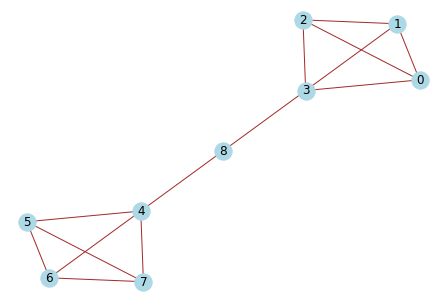

In [ ]:
G2 = nx.Graph()
[G2.add_node(node) for node in range(9)]
G2.add_edge(0, 1)
G2.add_edge(0, 2)
G2.add_edge(0, 3)
G2.add_edge(1, 2)
G2.add_edge(1, 3)
G2.add_edge(2, 3)

# G2.add_edge(3, 4)

G2.add_edge(4, 5)
G2.add_edge(4, 6)
G2.add_edge(4, 7)
G2.add_edge(5, 6)
G2.add_edge(5, 7)
G2.add_edge(6, 7)

G2.add_edge(3, 8)
G2.add_edge(4, 8)
# G2.add_edge(4, 9)
# G2.add_edge(8, 9)

nx.draw(G2, pos=nx.kamada_kawai_layout(G2), node_color='lightblue', edge_color='brown', with_labels=True)

Total Nodes: 9
Total Edges: 14
Modularity Baseline: 0.42602040816326536
Found 2 communities: 
[frozenset({0, 1, 2, 3, 8}), frozenset({4, 5, 6, 7})]


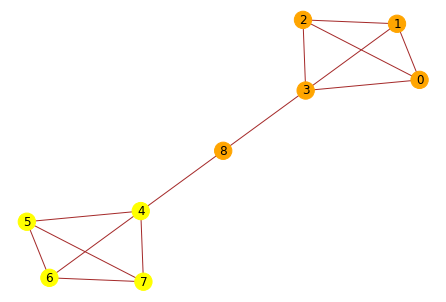

In [ ]:
print(f'Total Nodes: {len(G2.nodes())}')
print(f'Total Edges: {len(G2.edges())}')

baseline_communities2 = list(greedy_modularity_communities(G2))
baseline_modularity2 = modularity(G2, baseline_communities2)
print(f'Modularity Baseline: {baseline_modularity2}')
print(f'Found {len(baseline_communities2)} communities: \n{sorted(baseline_communities2)}')

colors = ['orange', 'yellow', 'lightgreen']
def get_color(label, communities):
    for index, community in enumerate(communities):
        if label in community:
            return colors[index]


nodes_color = [get_color(label, baseline_communities2) for label in G2.nodes()]
nx.draw(G2, pos=nx.kamada_kawai_layout(G2), node_color=nodes_color, edge_color='brown', with_labels=True)

In [ ]:
def define_possible_community_configurations(total_nodes, community_size):
    if community_size < 1 or community_size > total_nodes:
        raise Exception('community_size should be between 1 and total_nodes')
        
#     print(total_nodes, total_nodes - community_size + 1, community_size - 1)
    configs = []
    max_group = total_nodes - community_size + 1
    config = [max_group]
    remaining = [1] * (community_size - 1)
    if remaining:
        config += remaining
    
    configs += [config]
    
    can_reduce = True
    actual_config = config
    while can_reduce:
        actual_config = actual_config.copy()
        actual_config[0] -= 1
        for element in range(len(actual_config) - 1, 0, -1):
            left_neighbor = element - 1
            if actual_config[left_neighbor] > actual_config[element]:
                actual_config[element] += 1
                configs += [actual_config.copy()]
                break
        
        actual_config2 = actual_config.copy()
        can_move_left = True
#         print('actual_config', actual_config)
        while can_move_left:
            can_move_left = False
            for element in range(len(actual_config2) - 1, 1, -1):
                left_neighbor = element - 1
                if actual_config2[element] == 1:
                    continue
                else:
#                     print('b4', element, actual_config2[element], actual_config2)
                    for internal_element in range(element-1, 0, -1):
                        if actual_config2[internal_element - 1] > actual_config2[internal_element]:
#                             print(internal_element, element)
                            can_move_left = True
                            break
                        can_move_left = False
                    if (not can_move_left) or internal_element == 0:
                        break
#                     print('af', can_move_left, internal_element, element, actual_config2[element], actual_config2)
                    actual_config2[element] -= 1
                    actual_config2[internal_element] += 1
#                     print('actual_config2', actual_config2)
                    configs += [actual_config2.copy()]
                    break
        
        can_reduce = len(actual_config) > 1 and actual_config[0] > actual_config[1]
        
    
    return configs

# num_nodes = 6
# for num_communities in range(1, num_nodes + 1):
    # print('nodes', num_nodes, 'communities', num_communities, define_possible_community_configurations(num_nodes, num_communities))

In [ ]:
import itertools

def generate_communities(nodes):
    num_nodes = len(nodes)
    nodes_set = set(nodes)
    total_combinations = []
    total_communities = []
    for num_communities in range(1, num_nodes + 1):
        total_combinations += [define_possible_community_configurations(num_nodes, num_communities)]
    
    for combination_index, combination in enumerate(total_combinations):
        # print('-----------')
        # print('generating combinations of communities of size:', combination_index + 1)
        for community_distribution in combination:
            # print('community distribution', community_distribution)
            base = [list(item) for item in itertools.combinations(nodes, community_distribution[0])]
            product = base
#             print('base', community_distribution, base)
            
            for community_index in range(1, len(community_distribution)):
                remaining_nodes_list = []
                for base_element in base:
                    if isinstance(base_element[0], list):
#                         print('base_element', base_element)
                        base_element = list(itertools.chain(*base_element))
#                         print('base_element2', base_element)
                    remaining_nodes_list += [list(nodes_set - set(base_element))]
#                 print('base', community_distribution, base)
#                 print('remaining', community_distribution[community_index], 'remaining nodes', remaining_nodes_list)
                remaining_combinations = [list(itertools.combinations(remaining_nodes, community_distribution[community_index])) for remaining_nodes in remaining_nodes_list]
                
#                 print('remaining combinations', remaining_combinations)

                product = []
                index = 0
                for elements1, elements2 in zip(base, remaining_combinations):
                    if isinstance(elements1[0], tuple):
                        elements1 = [list(elements) for elements in elements1]
                    if isinstance(elements2[0], tuple):
                        elements2 = [list(elements) for elements in elements2]

#                     print('elements1', elements1)
#                     print('elements2', elements2)
                    if not isinstance(elements1[0], list):
                        elements1 = [elements1]
            
#                     print('base values', base[index], '<->', remaining_combinations[index])
#                     print('elements values', elements1, '<->', elements2)
#                     print('len(elements1)', len(elements1))
                    if len(elements1) == 1:
                        for item in itertools.product(elements1, elements2):
                            item = list(item)
    #                         print('item b4', item)
                            item.sort()
#                             print('product if', item, '->', item[0], '<->', item[1])
                            if item not in product:
                                product += [item]
                    else:
                        for item in itertools.product([elements1], elements2):
                            item_aux = list(item)
    #                         print('item b4', item)
#                             print('product else', item, '->', item[0], '<->', item[1])
                            item = [item_aux[0] + [item_aux[1]]]
                            item[0].sort()
#                             print('product else', item_aux, '->', item_aux[0], '<->', item_aux[1], 'final', item)
                            if item[0] not in product:
                                product += item
                    index += 1
#                 print('product', product)
                base = product
#                 print('product', [list(item) for item in itertools.product(base, remaining)])
#                 print('remaining', remaining)
#             print(base)                    

        total_communities.insert(combination_index, product)
#             print(list(itertools.combinations(nodes, community_distribution[0])))
    
    return total_communities
communities = generate_communities(G2.nodes())

In [ ]:
print('communities by size:')
for community_size, community in enumerate(communities):
    print(f'Total communities of size {community_size + 1}: {len(community)}')
    
print('Total possible communities:', sum([len(community) for community in communities]))

communities by size:
Total communities of size 1: 1
Total communities of size 2: 126
Total communities of size 3: 550
Total communities of size 4: 2520
Total communities of size 5: 1665
Total communities of size 6: 1260
Total communities of size 7: 378
Total communities of size 8: 36
Total communities of size 9: 1
Total possible communities: 6537


In [ ]:
def find_best_community(communities_found):
  best_community = []
  best_modularity = -1
  for community in communities_found:
      for combination in community:
          if not isinstance(combination[0], list):
              combination = [combination]
          actual_modularity = modularity(G2, combination)
          if actual_modularity > best_modularity:
              best_community = combination
              best_modularity = actual_modularity
  
  return best_community, best_modularity

best_community, best_modularity = find_best_community(communities)
print('Best modularity:', best_modularity, 'best community:', best_community)
print(f'Comparação: {best_modularity - baseline_modularity2}')

# print(f'Found {len(baseline_communities2)} communities: \n{sorted(baseline_communities2)}')

Best modularity: 0.42602040816326536 best community: [[0, 1, 2, 3, 8], [4, 5, 6, 7]]
Comparação: 0.0


In [ ]:
tempo = timeit.repeat(lambda: find_best_community(generate_communities(G2.nodes())), number=1, repeat=100)
total_amostras = len(tempo)
media = np.mean(tempo)
desvio_padrao = np.std(tempo)
print('quantidade de amostras', total_amostras, 'média', media, 'desvio padrão', desvio_padrao)

quantidade de amostras 100 média 17.979156249199995 desvio padrão 0.03958649533433491


In [ ]:
intervalo_confianca = .99
alfa = 1 - intervalo_confianca # significância

valor_normal_inicio = norm.ppf(alfa / 2)
valor_normal_fim = norm.ppf(intervalo_confianca + alfa / 2)

minimo_teste = media + valor_normal_inicio * desvio_padrao / np.sqrt(total_amostras)
maximo_teste = media + valor_normal_fim * desvio_padrao / np.sqrt(total_amostras)

print(f'Intervalo de Confiança para {intervalo_confianca * 100:.0f}%: ({minimo_teste}, {maximo_teste})')

Intervalo de Confiança para 99%: (17.968959443729297, 17.989353054670694)
